# An illustration of the MARBLE method on the Van der Pol oscillator

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import MARBLE
from MARBLE import plotting, dynamics, geometry

np.random.seed(42)

First create some plots to illustrate the limit cycle in two regimes ($\mu<0$ and $\mu>0)$

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


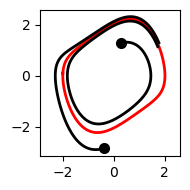

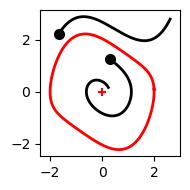

In [2]:
# simulate some long trajectories to plot attractor
t_long = np.arange(0, 100, 0.01)
area = [[-3, -3],[3, 3]]

mus_long = [0.5, 0.5, 0.5, -0.5, -0.5, -0.5, -0.5]
X0 = dynamics.initial_conditions(1, len(mus_long), area)
p_long, v_long = [], []
for X0, m in zip(X0, mus_long):
    p, v = dynamics.simulate_vanderpol(m, X0, t_long, keep_v=True)
    p_long.append(p[0])
    v_long.append(v[0])

plt.figure(figsize=(2, 2))
plt.plot(p_long[0][-640:, 0], p_long[0][-640:, 1], '-', c='r', lw=2)
plt.scatter(p_long[0][0, 0], p_long[0][0, 1], c='k', lw=2)
plt.plot(p_long[0][:700, 0], p_long[0][:700, 1], '-', c='k', lw=2)
plt.scatter(p_long[2][0, 0], p_long[2][0, 1], c='k', lw=2)
plt.plot(p_long[2][:400, 0], p_long[2][:400, 1], '-', c='k', lw=2)


plt.axis('equal')
plt.tight_layout()

#plt.savefig('traj_stable.pdf')


plt.figure(figsize=(2, 2))
plt.scatter(0, 0, c='r', marker='+')
plt.plot(-p_long[0][-640:, 0], p_long[0][-640:, 1], '-', c='r', lw=2)
plt.scatter(p_long[3][0, 0], p_long[3][0, 1], c='k', lw=2)
plt.plot(p_long[3][:700, 0], p_long[3][:700, 1], '-', c='k', lw=2)
plt.scatter(p_long[5][0, 0], p_long[5][0, 1], c='k', lw=2)
plt.plot(p_long[5][:180, 0], p_long[5][:180, 1], '-', c='k', lw=2)


plt.axis('equal')
plt.tight_layout()

#plt.savefig('traj_unstable.pdf')

Generate phase portraits over a parabola while varying $\mu$

In [3]:
def get_pos_vel(mus, alpha=0.05):
    X0_range = dynamics.initial_conditions(n, len(mus), area)

    pos, vel = [], []
    for X0, m in zip(X0_range, mus):
        p, v = dynamics.simulate_vanderpol(m, X0, t)
        pos.append(np.vstack(p))
        vel.append(np.vstack(v))

    pos, vel = dynamics.embed_parabola(pos, vel, alpha=alpha)
    return pos, vel

# Run MARBLE in geometry-agnostic mode on $\mu\in [-1,1]$

In [4]:
n_mus = 40
t = np.arange(0, 3, 0.5)
n = 100
area = [[-3, -3],[3, 3]]

mus = np.linspace(-1.0, 1.0, n_mus)
pos, vel = get_pos_vel(mus)

In [5]:
data = MARBLE.construct_dataset(anchor=pos, vector=vel, spacing=0.03)

---- Embedding dimension: 3
---- Signal dimension: 3


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


In [6]:
params = {'epochs': 50, #optimisation epochs
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 5,
       'inner_product_features': True,
      }

model = MARBLE.net(data, params=params)
model.fit(data, outdir='model_large')


---- Settings: 

epochs : 50
order : 2
hidden_channels : [32]
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
frac_sampled_nb : -1
include_positions : False
include_self : True
dropout : 0.0
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  731

---- Training network ...

Epoch: 0, Training loss: 1.350316, Validation loss: 1.2835, lr: 0.0100 *
Epoch: 1, Training loss: 1.256130, Validation loss: 1.1670, lr: 0.0100 *
Epoch: 2, Training loss: 1.159484, Validation loss: 1.1626, lr: 0.0100 *
Epoch: 3, Training loss: 1.120355, Validation loss: 1.1317, lr: 0.0100 *
Epoch: 4, Training loss: 1.107037, Validation loss: 1.1333, lr: 0.0100
Epoch: 5, Training loss: 1.080937, Validation loss: 1.0870, lr: 0.0100 *
Epoch: 6, Training loss: 1.084481, Validation loss: 1.0538, lr: 0.0100 *
Epoch: 7, T

# Show results: embedding, distance matrix and its MDS embedding 

Performed umap embedding on embedded results.
Performed MDS embedding on embedded results.


<Axes: >

<Figure size 400x400 with 0 Axes>

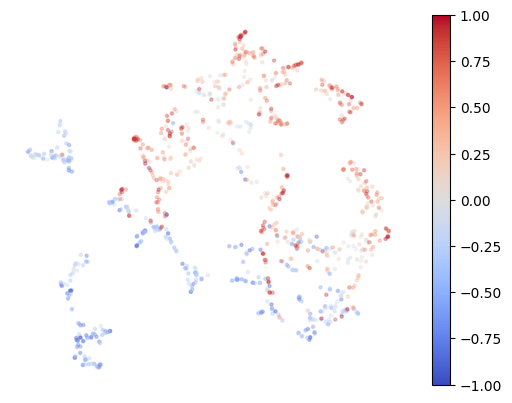

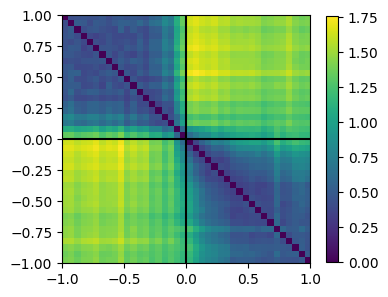

<Figure size 400x400 with 0 Axes>

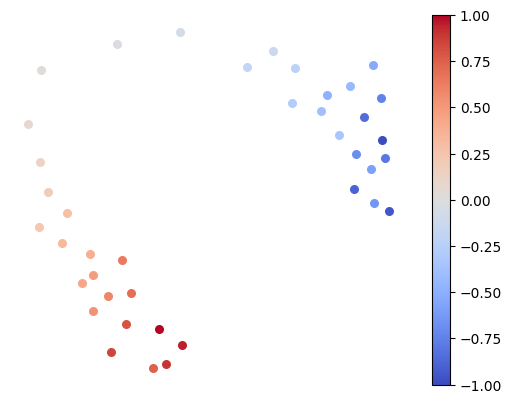

In [10]:
data = model.transform(data)
data = MARBLE.distribution_distances(data)
data = MARBLE.embed_in_2D(data)

plt.figure(figsize=(4, 4))
plotting.embedding(data, mus[data.y.numpy().astype(int)])

plt.figure(figsize=(4, 4))
im = plt.imshow(data.dist, extent=[mus[0], mus[-1], mus[0], mus[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.colorbar(im, shrink=0.8)

emb_MDS, _ = geometry.embed(data.dist, embed_typ='MDS')

plt.figure(figsize=(4, 4))
plotting.embedding(emb_MDS, mus, s=30, alpha=1)

# Now repeat for a smaller range $\mu\in[-0.1,0.1]$

In [8]:
mus = np.linspace(-0.1, 0.1, n_mus)
pos, vel = get_pos_vel(mus)

data = MARBLE.construct_dataset(anchor=pos, vector=vel, k=20, spacing=0.03)
model = MARBLE.net(data, params=params)
model.fit(data, outdir='model_zoom')

/Users/arnaudon/base/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


---- Embedding dimension: 3
---- Signal dimension: 3


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 

---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  731

---- Training network ...

Epoch: 0, Training loss: 1.309698, Validation loss: 1.2128, lr: 0.0100 *
Epoch: 1, Training loss: 1.122567, Validation loss: 1.1218, lr: 0.0100 *
Epoch: 2, Training loss: 1.087854, Validation loss: 1.0621, lr: 0.0100 *
Epoch: 3, Training loss: 1.069521, Validation loss: 1.1066, lr: 0.0100
Epoch: 4, Training loss: 1.058513, Validation loss: 1.0869, lr: 0.0100
Epoch: 5, Training loss: 1.06579

Show results: embedding, distance matrix and its MDS embedding 

Performed umap embedding on embedded results.
[7.81512278e-01 1.60675295e-01 2.19012697e-02 5.19371448e-03
 2.78597422e-03 2.15143149e-03 1.73000459e-03 1.61541572e-03
 1.45093906e-03 1.33295136e-03 1.25398340e-03 1.18964213e-03
 1.09815260e-03 1.04377891e-03 9.75453147e-04 9.22878174e-04
 8.68403382e-04 8.10130618e-04 7.81357332e-04 7.45713509e-04]
Performed PCA embedding on embedded results.


<Figure size 400x400 with 0 Axes>

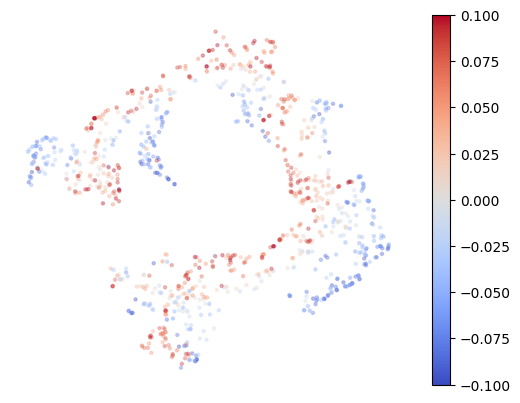

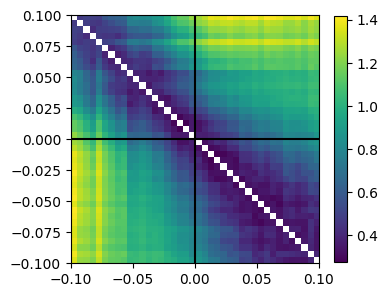

<Figure size 400x400 with 0 Axes>

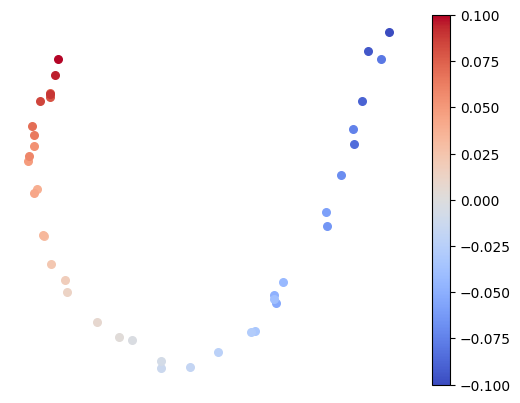

In [9]:
data = model.transform(data)
data = MARBLE.distribution_distances(data)
data = MARBLE.embed_in_2D(data)

plt.figure(figsize=(4, 4))
plotting.embedding(data, mus[data.y.numpy().astype(int)])

plt.figure(figsize=(4, 4))
im = plt.imshow(data.dist, extent=[mus[0], mus[-1], mus[0], mus[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.colorbar(im, shrink=0.8)

emb_MDS, _ = geometry.embed(data.dist, embed_typ='MDS')

plt.figure(figsize=(4, 4))
plotting.embedding(emb_MDS, mus, s=30, alpha=1)

# Repeat for changing parabola curvature

In [13]:
from scipy.stats import special_ortho_group
def get_pos_vel_noise(mus, alpha=0.05):
    X0_range = dynamics.initial_conditions(n, len(mus), area)

    pos, vel = [], []
    for X0, m in zip(X0_range, mus):
        p, v = dynamics.simulate_vanderpol(m, X0, t)
        a = np.random.uniform(-alpha, alpha)
        p, v = dynamics.embed_parabola(p, v, alpha=alpha)
        p = np.vstack(p)
        shift = np.random.uniform(-2, 2, 3)
        pos.append(p+shift)
        v = np.vstack(v)
        vel.append(v)
   
    return pos, vel

In [11]:
mus = np.linspace(-0.1, 0.1, n_mus)
pos, vel = get_pos_vel_noise(mus, alpha=0.2)

data = MARBLE.construct_dataset(anchor=pos, vector=vel, k=20, spacing=0.03)

params['inner_product_features'] = True
model = MARBLE.net(data, params=params)
model.fit(data, outdir='model_noise_inner')

/Users/arnaudon/base/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


---- Embedding dimension: 3
---- Signal dimension: 3


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 

---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  731

---- Training network ...

Epoch: 0, Training loss: 1.270293, Validation loss: 1.1471, lr: 0.0100 *
Epoch: 1, Training loss: 1.101365, Validation loss: 1.1040, lr: 0.0100 *
Epoch: 2, Training loss: 1.090652, Validation loss: 1.0912, lr: 0.0100 *
Epoch: 3, Training loss: 1.087600, Validation loss: 1.1217, lr: 0.0100
Epoch: 4, Training loss: 1.070062, Validation loss: 1.1001, lr: 0.0100
Epoch: 5, Training loss: 1.05992

Show results: embedding, distance matrix and its MDS embedding 

Performed umap embedding on embedded results.
[7.95607375e-01 1.44411457e-01 2.30742858e-02 5.08080093e-03
 2.90027592e-03 2.35954896e-03 1.94219041e-03 1.66585442e-03
 1.59532236e-03 1.47309818e-03 1.29247175e-03 1.20334681e-03
 1.06882474e-03 1.05954940e-03 1.01979882e-03 9.58909345e-04
 9.34311776e-04 8.44336650e-04 7.83924137e-04 7.78109191e-04]
Performed PCA embedding on embedded results.


<Figure size 400x400 with 0 Axes>

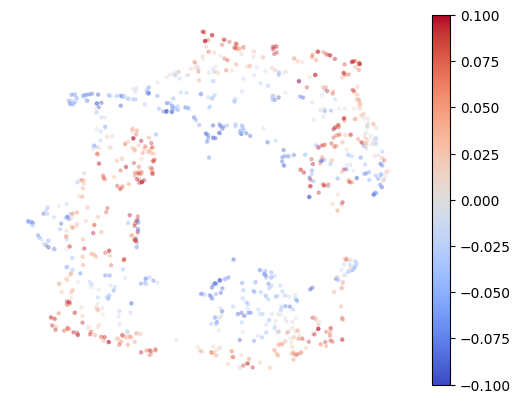

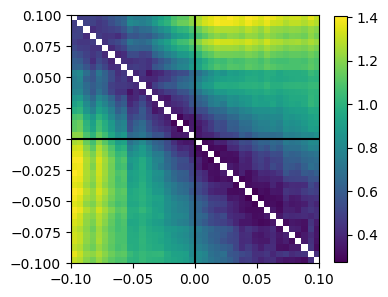

<Figure size 400x400 with 0 Axes>

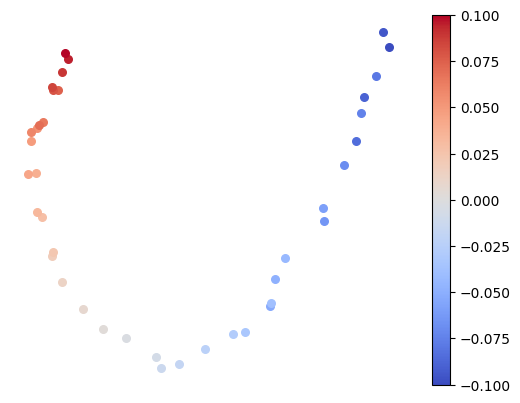

In [12]:
data = model.transform(data)
data = MARBLE.distribution_distances(data)
data = MARBLE.embed_in_2D(data)

plt.figure(figsize=(4, 4))
plotting.embedding(data, mus[data.y.numpy().astype(int)])

plt.figure(figsize=(4, 4))
im = plt.imshow(data.dist, extent=[mus[0], mus[-1], mus[0], mus[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.colorbar(im, shrink=0.8)

emb_MDS, _ = geometry.embed(data.dist, embed_typ='MDS')

plt.figure(figsize=(4, 4))
plotting.embedding(emb_MDS, mus, s=30, alpha=1)

# Finally changing parabola curvature in geometry-aware mode

In [13]:
params['inner_product_features'] = False
model = MARBLE.net(data, params=params)
model.fit(data, outdir='model_noise_no_inner')

{'epochs': 50, 'order': 2, 'hidden_channels': 32, 'out_channels': 5, 'inner_product_features': False}

---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : False
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  39
---- Total number of parameters:  1446

---- Training network ...

Epoch: 0, Training loss: 1.178733, Validation loss: 1.0988, lr: 0.0100 *
Epoch: 1, Training loss: 1.087753, Validation loss: 1.0632, lr: 0.0100 *
Epoch: 2, Training loss: 1.054849, Validation loss: 1.0655, lr: 0.0100
Epoch: 3, Training loss: 1.042628, Validation loss: 1.0952, lr: 0.0100
Epoch: 4, Training loss: 1.043448, Validation loss: 1.0452, lr: 0.0100 *
Epoch: 5, Training loss: 1.008961, Validation loss: 1.0300, 

Show results: embedding, distance matrix and its MDS embedding 

Performed umap embedding on embedded results.
[0.60698056 0.17498294 0.0273568  0.02369231 0.01579797 0.01146069
 0.00915862 0.00767861 0.00730429 0.00702643 0.00626766 0.0059338
 0.00574809 0.00556621 0.00535531 0.00495709 0.00472026 0.00442305
 0.0043491  0.00428855]
Performed PCA embedding on embedded results.


<Figure size 400x400 with 0 Axes>

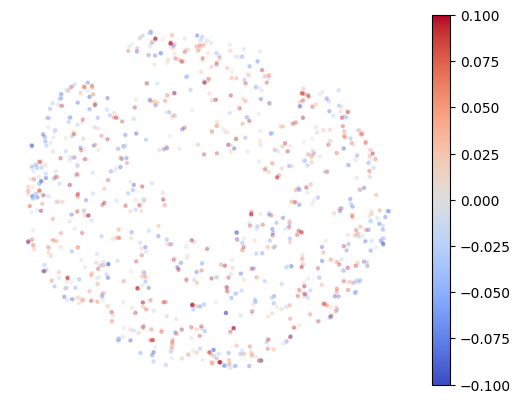

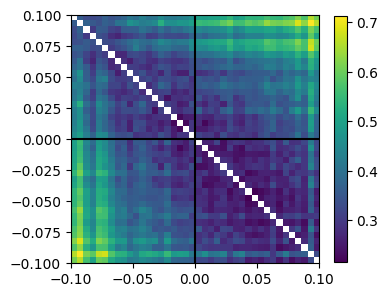

<Figure size 400x400 with 0 Axes>

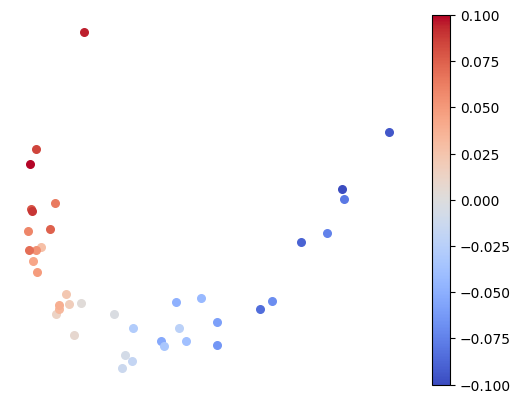

In [14]:
data = model.transform(data)
data = MARBLE.distribution_distances(data)
data = MARBLE.embed_in_2D(data)

plt.figure(figsize=(4, 4))
plotting.embedding(data, mus[data.y.numpy().astype(int)])

plt.figure(figsize=(4, 4))
im = plt.imshow(data.dist, extent=[mus[0], mus[-1], mus[0], mus[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.colorbar(im, shrink=0.8)

emb_MDS, _ = geometry.embed(data.dist, embed_typ='MDS')

plt.figure(figsize=(4, 4))
plotting.embedding(emb_MDS, mus, s=30, alpha=1)